# Credit Card Fraud Detection — EDA & Validation Strategy

This notebook explores the credit card fraud dataset with a focus on
class imbalance, time structure, and validation strategy design for
robust model evaluation.


## Importing Libraries

In [2]:
import numpy as np          
import pandas as pd     
import matplotlib.pyplot as plt    
import seaborn as sns          

## Loading Raw Data

In [3]:
df = pd.read_csv("../data/raw/creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Dataset Overview

In [4]:
print(f"Shape: {df.shape}")
display(df.dtypes)

Shape: (284807, 31)


Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

In [5]:
# Checking Missing Values
missing = df.isna().sum().sort_values(ascending=False)
display(missing[missing > 0])
print(f"Total Missing Values: {df.isna().sum().sum()}")

# Checking Duplicate Rows
dup_count = df.duplicated().sum()
print(f"\nDuplicate rows: {dup_count}")

Series([], dtype: int64)

Total Missing Values: 0

Duplicate rows: 1081


In [6]:
# Removing Duplicate Rows
df = df.drop_duplicates().reset_index(drop=True)

## Target distribution (Class imbalance)


Class
0    283253
1       473
Name: count, dtype: int64

Fraud rate: 0.001667101358352777


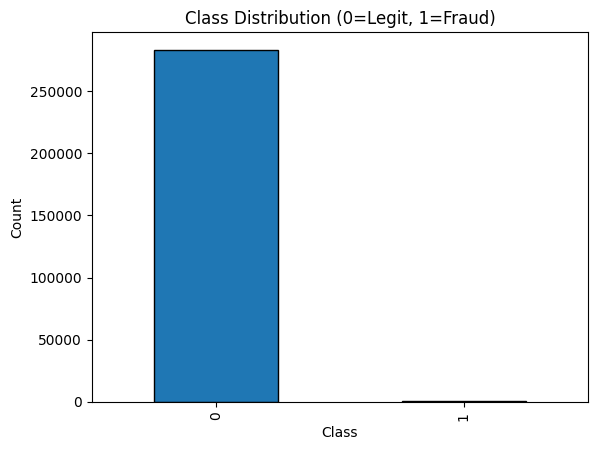

In [7]:
# Target Column Information
class_counts = df["Class"].value_counts()
class_ratio = df["Class"].value_counts(normalize=True)
print(f"\n{class_counts}")
print(f"\nFraud rate: {class_ratio.get(1, 0)}")

# Bar Plot
ax = df["Class"].value_counts().plot(kind="bar", edgecolor="black")
ax.set_title("Class Distribution (0=Legit, 1=Fraud)")
ax.set_xlabel("Class")
ax.set_ylabel("Count")
plt.show()

- The dataset is extremely imbalanced, with fraud cases representing
a very small fraction of total transactions.

- Accuracy is therefore not a meaningful metric.
Evaluation must focus on recall, precision, PR-AUC, and thresholding.

## Amount analysis (fraud vs legit)

In [8]:
# Summary stats by class
df.groupby("Class")["Amount"].describe()

,count,mean,std,min,25%,50%,75%,max
Class,,,,,,,,
0,283253.0,88.413575,250.379023,0.0,5.67,22.00,77.46,25691.16
1,473.0,123.871860,260.211041,0.0,1.00,9.82,105.89,2125.87


- Fraudulent transactions have a higher mean but lower median than legitimate ones, indicating strong right-skew. Most fraud cases involve small amounts, with a few large outliers increasing the mean.


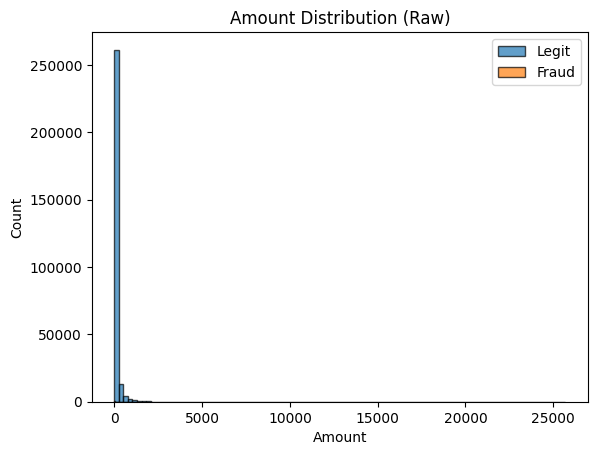

In [38]:
# Plotting the Distribution
plt.hist(df.loc[df["Class"] == 0, "Amount"], bins=100, alpha=0.7, edgecolor="black", label="Legit")
plt.hist(df.loc[df["Class"] == 1, "Amount"], bins=100, alpha=0.7, edgecolor="black", label="Fraud")
plt.title("Amount Distribution (Raw)")
plt.xlabel("Amount")
plt.ylabel("Count")
plt.legend()
plt.show()

- The raw Amount feature is heavily right-skewed with a long tail. Large values dominate the scale, making class comparison difficult.

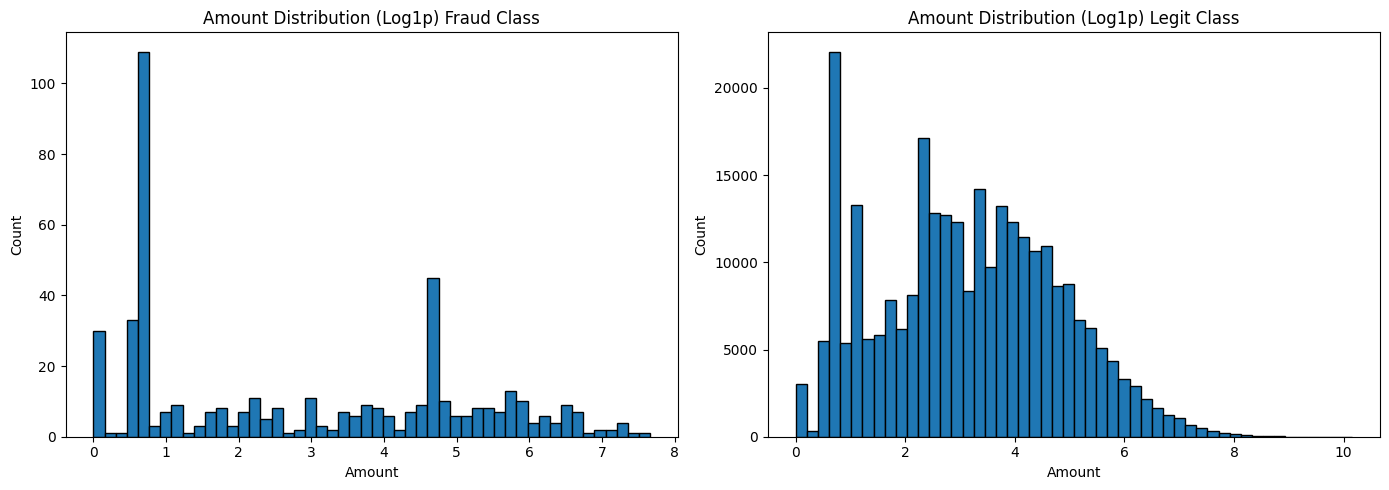

In [48]:
# Applying Log Transformation
df["LogAmount"] = np.log1p(df["Amount"])

fraud = df.loc[df["Class"] == 1, "LogAmount"]
legit = df.loc[df["Class"] == 0, "LogAmount"]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))

ax1.hist(fraud, bins=50, edgecolor="black")
ax1.set_title("Amount Distribution (Log1p) Fraud Class")
ax1.set_xlabel("Amount")
ax1.set_ylabel("Count")


ax2.hist(legit, bins=50, edgecolor="black")
ax2.set_title("Amount Distribution (Log1p) Legit Class")
ax2.set_xlabel("Amount")
ax2.set_ylabel("Count")

plt.tight_layout()
plt.show()


- After log transformation, class differences become clearer. Fraud transactions cluster at lower values. Log transformation improves interpretability and modeling suitability.

## Time analysis (fraud patterns over time)

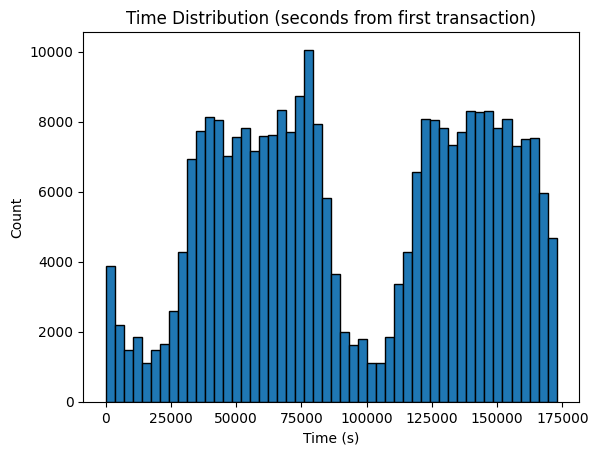

In [9]:
plt.hist(df["Time"], bins=50, edgecolor="black")
plt.title("Time Distribution (seconds from first transaction)")
plt.xlabel("Time (s)")
plt.ylabel("Count")
plt.show()

- Transactions span roughly 48 hours and show a clear daily cycle. Time reflects behavioral patterns rather than a linear trend.


In [10]:
df["Hour"] = df["Time"] // 3600 # Converting seconds to hours

fraud_rate_by_hour = df.groupby("Hour")["Class"].mean()
count_by_hour = df.groupby("Hour")["Class"].size()

display(pd.DataFrame({"Transactions" : count_by_hour,
                      "Fraud Rate": fraud_rate_by_hour}).head())

,Transactions,Fraud Rate
Hour,,
0.0,3963,0.000505
1.0,2217,0.000902
2.0,1576,0.013325
3.0,1821,0.007139
4.0,1082,0.005545


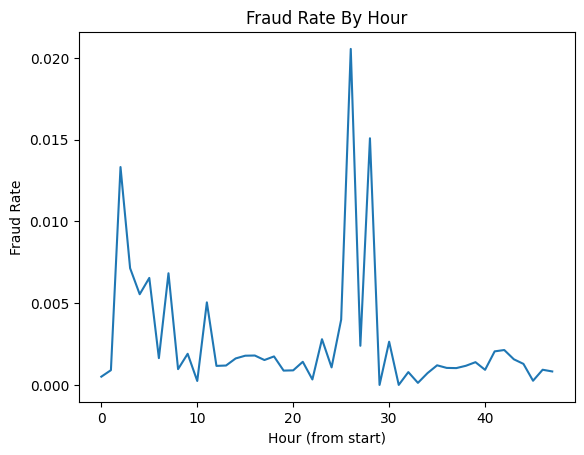

In [11]:
# Plotting fraud rate
plt.plot(fraud_rate_by_hour.index, fraud_rate_by_hour.values)
plt.title("Fraud Rate By Hour")
plt.xlabel("Hour (from start)")
plt.ylabel("Fraud Rate")
plt.show()

- Fraud rate varies across hours and shows localized spikes. Fraud occurrence is temporally clustered, not uniform.


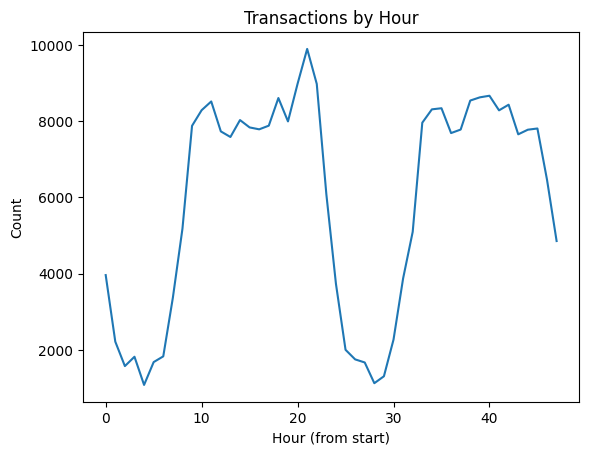

In [12]:
#Transcations Volume
plt.plot(count_by_hour.index, count_by_hour.values)
plt.title("Transactions by Hour")
plt.xlabel("Hour (from start)")
plt.ylabel("Count")
plt.show()

- Transaction volume follows a clear cyclical pattern, with noticeable peaks and dips across hours. This suggests recurring daily activity behavior. 

## PCA Feature Selection

In [13]:
# Selecting PCA columns
v_cols = [c for c in df.columns if c.startswith("V")]

# Class Conditional Means
mean_legit = df.loc[df["Class"] == 0, v_cols].mean()
mean_fraud = df.loc[df["Class"] == 1, v_cols].mean()

# Absolute difference in mean between classes
sep_score = (mean_fraud - mean_legit).abs().sort_values(ascending=False)

top_v = sep_score.head(8).index.tolist()

sep_score.head(12)

V3     7.045452
V14    6.983787
V17    6.677371
V12    6.270225
V10    5.686707
V7     5.578368
V1     4.780206
V4     4.549889
V16    4.147110
V11    3.806749
V2     3.630049
V5     3.156678
dtype: float64

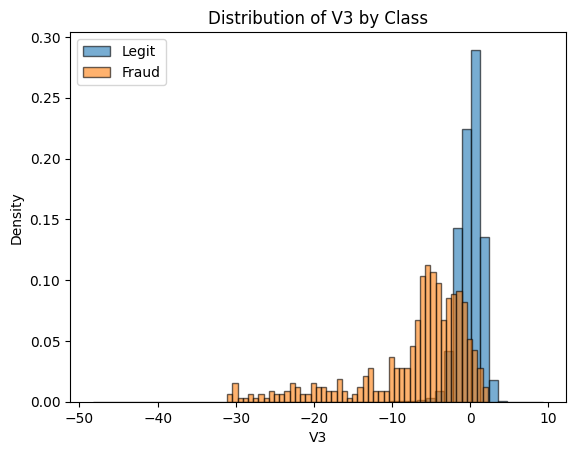

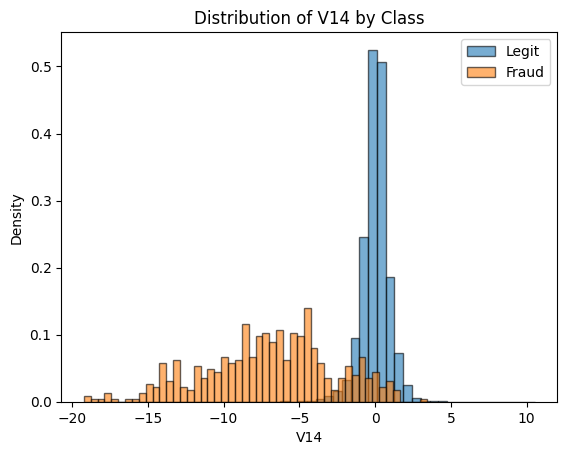

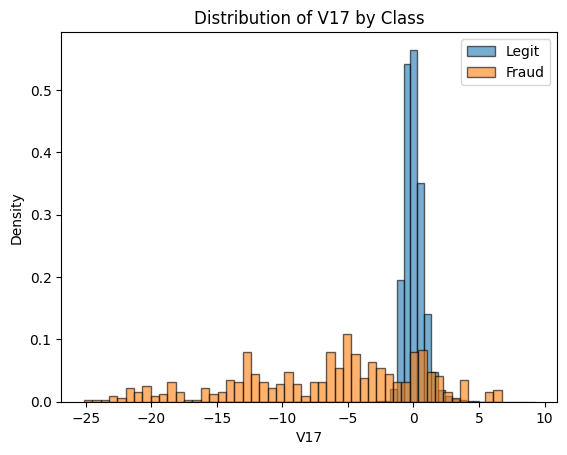

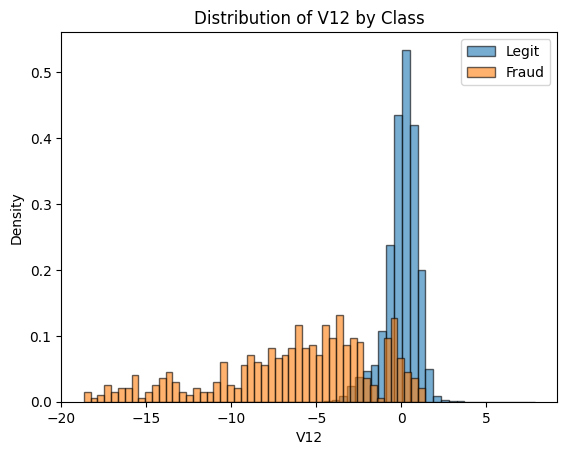

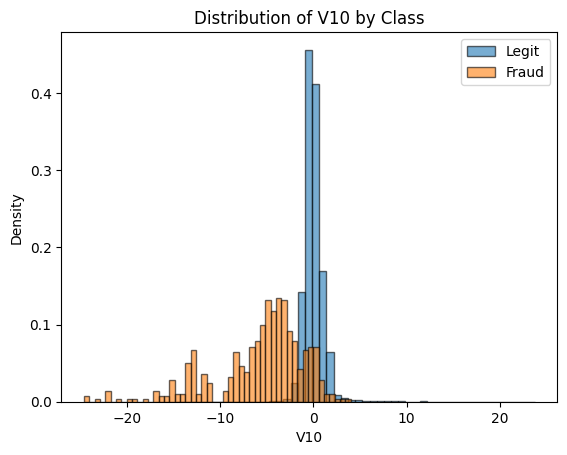

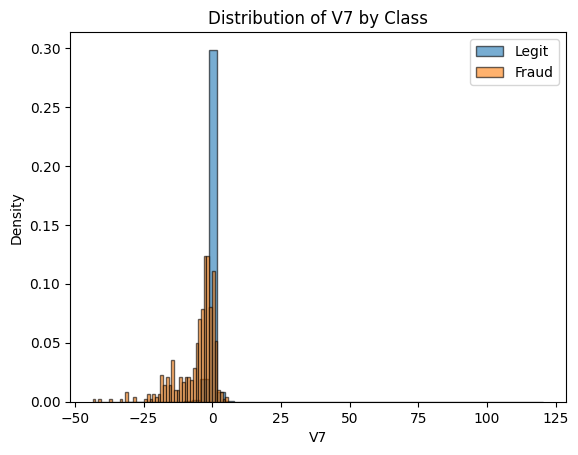

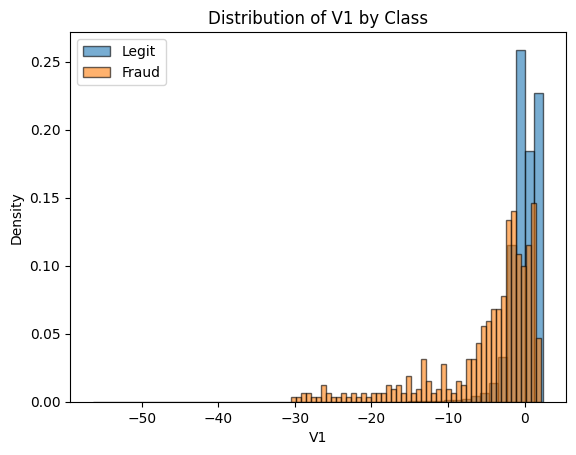

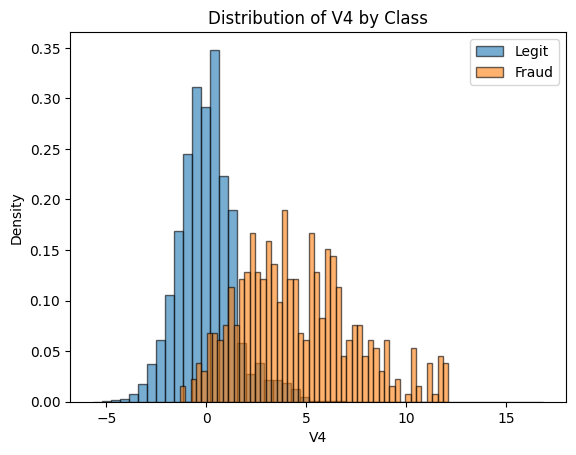

In [23]:
# Plotting Distribution for Top-V Features
for col in top_v:
    plt.hist(df.loc[df["Class"] == 0, col], density=True, bins=50, alpha= 0.6, edgecolor="black", label="Legit")
    plt.hist(df.loc[df["Class"] == 1, col], density=True, bins=50, alpha=0.6, edgecolor="black", label="Fraud")
    plt.title(f"Distribution of {col} by Class")
    plt.xlabel(col)
    plt.ylabel("Density")
    plt.legend()
    plt.show()

- Class-conditional distributions of top PCA components (V3, V14, V17, V12, V10) show strong separation between fraudulent and legitimate transactions. Fraud cases exhibit significantly shifted and heavier-tailed distributions, indicating that fraudulent behavior corresponds to extreme deviations in the transformed feature space. These features are therefore expected to be highly predictive and were prioritized for modeling.

## Correlation analysis

In [19]:
corr_with_class = df.drop(columns=["LogAmount", "Hour"], errors="ignore").corr()["Class"].sort_values()

corr_v = df[v_cols].corr()

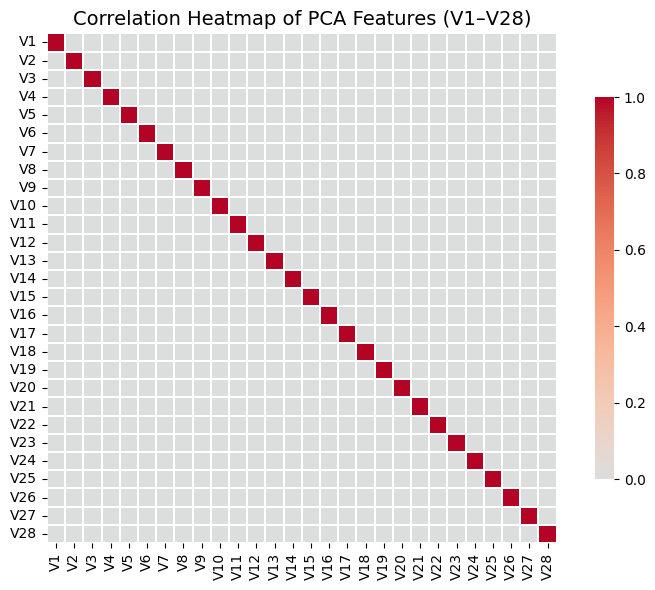

In [22]:
# Creating heatmap for correlation matrix
plt.figure(figsize=(8, 6))

sns.heatmap(
    corr_v,
    cmap="coolwarm",
    center=0,
    square=True,
    linewidths=0.1,
    cbar_kws={"shrink": 0.75}
)

plt.title("Correlation Heatmap of PCA Features (V1–V28)", fontsize=14)
plt.tight_layout()
plt.show()

- A correlation heatmap of PCA features (V1–V28) shows near-zero off-diagonal correlations, which is expected as the dataset has been preprocessed using PCA. Therefore, correlation analysis between PCA components does not provide meaningful insights and was not used for feature selection.

## Outlier checks

In [ ]:
# Amount outliers via quantiles
df["Amount"].quantile([0.5, 0.9, 0.95, 0.99, 0.999])

0.500      22.00
0.900     203.00
0.950     365.00
0.990    1017.97
0.999    3000.00
Name: Amount, dtype: float64

- This output shows how extreme transaction amounts get, confirming that the data is heavily skewed and needs log transformation rather than outlier removal.

In [25]:
# Compare extreme Amount transactions by class

threshold = df["Amount"].quantile(0.99)
top_amount = df[df["Amount"] >= threshold]

top_amount["Class"].value_counts(normalize=True)

Class
0    0.996841
1    0.003159
Name: proportion, dtype: float64

- Transactions in the top 1% by amount have nearly double the baseline fraud rate, indicating amount is a risk-enhancing but insufficient standalone feature.

In [26]:
# Scaling validation
summary = df[["Time", "Amount"] + top_v].describe().T
summary[["mean", "std", "min", "max"]]

,mean,std,min,max
Time,9.481386e+04,47488.145955,0.000000,172792.000000
Amount,8.834962e+01,250.120109,0.000000,25691.160000
V3,-1.379537e-15,1.516255,-48.325589,9.382558
V14,1.213481e-15,0.958596,-19.214325,10.526766
V17,-3.768179e-16,0.849337,-25.162799,9.253526
V12,-1.245415e-15,0.999201,-18.683715,7.848392
V10,2.238554e-15,1.088850,-24.588262,23.745136
V7,-5.620335e-16,1.237094,-43.557242,120.589494
V1,1.175161e-15,1.958696,-56.407510,2.454930
V4,2.094852e-15,1.415869,-5.683171,16.875344


- V1–V28 are already PCA outputs (roughly centered/scaled)
- Amount is skewed and on a different scale → scale it
- Time is large and not scaled → often scale it too

In [30]:
# Saving Processed Dataset
df.to_csv("../data/processed/creditcard_processed.csv", index=False)

## Conclusion

The dataset is clean, with no missing values and no categorical features. The target variable is extremely imbalanced, with fraudulent transactions representing approximately 0.17% of all observations, indicating that accuracy is not an appropriate evaluation metric for modeling.

Features V1–V28 are anonymized principal components derived via PCA. As expected, correlation analysis between these features shows near-zero off-diagonal values and does not provide meaningful insights; therefore, inter-feature correlation was not used for feature selection.

Instead, class-conditional distribution analysis was performed. Several PCA components—most notably V3, V14, V17, V12, and V10—exhibit strong separation between fraudulent and legitimate transactions. Fraud cases consistently show shifted distributions and heavy tails, indicating that fraudulent behavior corresponds to extreme deviations in the transformed feature space rather than subtle changes.

Transaction Amount is highly right-skewed and differs in distribution between classes; a log transformation improves interpretability. The Time feature shows non-uniform fraud occurrence over the transaction period, suggesting temporal patterns but no linear relationship.

Overall, the EDA indicates that the dataset contains strong discriminative signal within a small subset of PCA components, while effective modeling will primarily depend on appropriate handling of class imbalance and the use of metrics such as precision-recall and ROC-AUC rather than feature engineering.